
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 7 - Model Based Reinforcement Learning </b></center></h2>

<br>
<center><font size="3">This notebook is a part of teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Cross Entropy Method (CEM) </a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>
* <a href='#4.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Implementing CEM (30 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Changing Number of Samples (10 points)</a>\
<a href='#Q2'><b>Student Question 1.2</b> Model-free vs Mode-based RL (20 points)</a>
    
**Total Points:** 60

# 1. Introduction <a id='1.'></a>
In this exercise we will dive into model-based reinforcement learning. We will implement planning over several time steps. We will use the cross entropy method (CEM) to choose actions at each time step. CEM is often used in model-based reinforcement learning for choosing actions. The main working principles of CEM were explained during the lecture "Model-based RL". We use the simulator to simulate state transitions (another possibility would be to learn a dynamics model $s_{t+1} = f(s_t, a_t)$ to simulate state transitions if access to the system dynamics is not available).

## 1.1 Learning Objectives: <a id='1.1'></a>
- Understand how to get CEM planning working in practice
- Understand limitations and advantages of model-based RL using CEM

## 1.2 Code Structure & Files <a id='1.2'></a>

You don’t have to edit any other file other than ```ex7.ipynb``` to complete this exercise.

```
├───imgs                 # Images used in notebook
│   ex7_CEM.ipynb        # Main assignment file containing tasks <---------
│   env.py               # Wrappers for the environment
|   simulator.py         # Using the exact environment as the model (simulator)
```

# 2. Cross Entropy Method (CEM) <a id='2.'></a>

In this section, we will try to solve the **Cup-Catch** environment from the [DeepMind Control Suite](https://github.com/deepmind/dm_control/tree/main/dm_control/suite) by planning using CEM. 

In **Cup-Catch**, a ball is attached to a string which hangs from a cup. The goal is to swing the ball into the cup by moving the cup vertically up and down. The task has a sparse reward: 1 when the ball is in the cup, 0 otherwise. In order to save computation time we select an action every six time steps and use a wrapper to repeat the same action 6 times. Therefore, the maximum reward for each actual time step is 6.

<br>

<div style="text-align: center;">
    <img src="imgs/cup_catcher.png" width="400px">
    <figcaption> Figure 1: Cup-Catch environment </figcaption>
</div>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implementing CEM (30 points) </h3> 

You need to complete the planning part in the code marked as ```TODO```. The code takes advantage of multiple processor cores by parallelizing the code. For more information about parallelizing, please check [Joblib](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html). <br>
    
**Ensure that the notebook contains the reward plot.** 

The reference training plot is as Figure 2:

<div style="text-align: center;">
    <img src="imgs/cem_reward.png">
    <figcaption> Figure 2: Reward function at each time step in CEM </figcaption>
</div>
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [2]:
from pathlib import Path # to find directory
import sys, os
sys.path.append("..")

from typing import Sequence, Tuple, Dict, Callable, List
from functools import partial
import copy, torch, time
from joblib import Parallel, delayed
import numpy as np

from env import make_env
from simulator import SimulatorWrapper
import matplotlib.pyplot as plt

In [3]:
%%capture
!pip install mediapy # install a package required for video visualization

In [41]:
class CEM(object):
    def __init__(
        self, 
        model,
        action_shape,
        num_samples,
        num_topk,
        plan_horizon,
        iteration,
        keep_last_solution,
        expl_noise
    ):

        self.model = model # the dynamics model

        self.action_dim = action_shape[0]
        self.num_samples = num_samples
        self.num_topk = num_topk
        self.plan_horizon = plan_horizon # trajectory 
        self.iteration = iteration
        self.keep_last_solution = keep_last_solution
        self.expl_noise = expl_noise

        # init simulator
        o = self.model.reset()
        self.model.save_checkpoint()
        
    def plan(self, obs, t0, eval_mode=False):
        if obs.ndim == 1: obs = obs[None] # add batch dim
        # initialize paramters
        mean = np.zeros((self.plan_horizon, self.action_dim))
        std = np.ones_like(mean)
        # use previous plan as start point if not at the first step
        if not t0 and hasattr(self, "_prev_mean"):
            mean[:-1] = copy.copy(self._prev_mean[1:])

        with Parallel(n_jobs=-1,) as parallel:  # we use joblib.Parallel to parallel the evaluation.
            # Iterate CEM
            for _ in range(self.iteration):
                # TODO: Implement Cross-Entropy Method
                
                # Hints: 
                # 1. Generate random actions using Gaussian distribution with mean and std as parameters. 
                #    Use self.num_samples as the number of samples. Clip the samples to (-1, 1).
                # 2. Perform Monte Carlo evaluation by computing the episode return for each sample using self.model as follows:
                #    2.1. Use parallel(delayed(rollout_simulator)(self.model, action_sample) for each sample from 1.
                # 3. Select top self.num_topk actions (elite actions) using episode returns from 2.1. Use numpy.argpartition.
                # 4. Compute mean and std of elite actions and assign it to mean and std used in 1.
                
                ########## Your code starts here. ##########
                # generate random actions from Gaussian distribution 
                action_samples =  np.random.randn(self.num_samples, self.plan_horizon, self.action_dim) * std + mean
                action_samples = np.clip(action_samples, a_min=-1, a_max=1) # NOTE: clip to (-1, 1)
                
                # perform MC evaluation
                episode_returns = parallel(delayed(rollout_simulator)(self.model, sample) for sample in action_samples) # NOTE: for each sample 
                # select action samples with top k episode returns
                topk_action_samples = action_samples[np.argpartition(episode_returns, kth=-self.num_topk)[-self.num_topk:]] # NOTE: -topk
                # update with mean and std of elite actions 
                mean = np.mean(topk_action_samples, axis=0) # NOTE: axis
                std = np.std(topk_action_samples, axis=0)
                ########## Your code ends here. ##########

        if self.keep_last_solution:
            self._prev_mean = mean

        # select the first action in the planed horizon
        action, std = mean[0], std[0]

        if not eval_mode:
            action += self.expl_noise * np.random.randn(action.shape)

        # update the simulator state since simulator is used to do planning
        next_obs, reward, done, info = self.model.step(action)
        self.model.save_checkpoint()
        
        return action, info  
        

def rollout_simulator(model, traj):
    model.load_checkpoint()

    terminated, episode_return = False, 0
    for act in traj:
        obs, reward, done, _ = model.step(act)
        reward = 0 if terminated else reward

        terminated |= bool(done)
        episode_return += reward
        
        if done: 
            break
        
    return episode_return

In [42]:
# Note because of the action repeat a reward of 6 can be achieved from multiple steps being taken where the ball in the cup
eval_env = make_env(
    env_name='cup-catch',
    seed=1,
    action_repeat=6,
    modality='pixels', 
    frame_stack=1,
    img_size=(240, 320)
)

model_env = make_env(
    env_name='cup-catch',
    seed=1,
    action_repeat=6
)

obs_shape = tuple(int(x) for x in eval_env.observation_space.shape)
action_shape = tuple(int(x)  for x in eval_env.action_space.shape)

model = SimulatorWrapper(model_env)

agent = CEM(
    model=model,
    action_shape = action_shape,
    num_samples=50,
    num_topk=5,
    plan_horizon=12,
    iteration=5,
    keep_last_solution=True,
    expl_noise=0.3
)

In [43]:
obs, done, ep_reward, t = eval_env.reset(), False, 0, 0
rewards, observations = [], []
while not done and t < 20:
    action, info = agent.plan(obs, eval_mode=True, t0=(t==0))
    obs, reward, done, _ = eval_env.step(action)
    rewards.append(reward)
    observations.append(obs)
    
    print(f'Timestep: {t} Reward: {reward}')
    ep_reward += reward

    t += 1

Timestep: 0 Reward: 0.0
Timestep: 1 Reward: 0.0
Timestep: 2 Reward: 0.0
Timestep: 3 Reward: 0.0
Timestep: 4 Reward: 0.0
Timestep: 5 Reward: 0.0
Timestep: 6 Reward: 3.0
Timestep: 7 Reward: 6.0
Timestep: 8 Reward: 6.0
Timestep: 9 Reward: 6.0
Timestep: 10 Reward: 6.0
Timestep: 11 Reward: 6.0
Timestep: 12 Reward: 6.0
Timestep: 13 Reward: 6.0
Timestep: 14 Reward: 6.0
Timestep: 15 Reward: 6.0
Timestep: 16 Reward: 6.0
Timestep: 17 Reward: 6.0
Timestep: 18 Reward: 6.0
Timestep: 19 Reward: 6.0


In [44]:
import mediapy 
mediapy.write_video('video.mp4', [observations[i].transpose(1, 2, 0) for i in range(len(observations))], fps=10)

In [45]:
from IPython.display import Video # to display videos
Video(Path().cwd()/'video.mp4', embed=True)

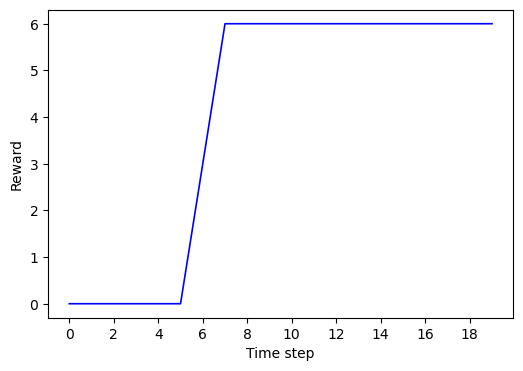

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(rewards, linewidth=1.2, color='b')
plt.xticks(list(range(0, len(rewards), 2)))
plt.xlabel('Time step', fontsize=10)
plt.ylabel('Reward', fontsize=10)
plt.show()

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1</b> Changing Number of Samples (5 points)</h3> 

Discuss the effect of changing the __number of samples__. How can this affect the performance and running time?            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

The number of (action trajectory) samples refer to the number of action trajectories generated and evaluated for each iterate (set of policy parameters). By *increasing* the number of samples, 
1. performance is improved as increased number of samples enables broader exploration, leading to a larger possibility of finding out a better policy. Besides, more samples aka training data lead to a faster convergence. 
2. the running time is increased since each trajectory requires evaluation, which is one of the most computationally costly step in the algorithm. 

To validate, reward curves and running time when training on different number of samples(`[5, 10, 25, 50]`) with a fixed number of steps($20$) are shown below. 

In [60]:
import time 

num_sample_list = [5, 35, 50]
reward_list, training_time_list = list(), list()

for num_samples in num_sample_list:
    st = time.time()
    eval_env = make_env(
        env_name='cup-catch',
        seed=1,
        action_repeat=6,
        modality='pixels', 
        frame_stack=1,
        img_size=(240, 320)
    )

    model_env = make_env(
        env_name='cup-catch',
        seed=1,
        action_repeat=6
    )

    obs_shape = tuple(int(x) for x in eval_env.observation_space.shape)
    action_shape = tuple(int(x)  for x in eval_env.action_space.shape)

    model = SimulatorWrapper(model_env)
    agent = CEM(
        model=model,
        action_shape = action_shape,
        num_samples=num_samples,
        num_topk=5,
        plan_horizon=12,
        iteration=5,
        keep_last_solution=True,
        expl_noise=0.3
    )
    obs, done, ep_reward, t = eval_env.reset(), False, 0, 0
    rewards, observations = [], []
    while not done and t < 20:
        action, info = agent.plan(obs, eval_mode=True, t0=(t==0))
        obs, reward, done, _ = eval_env.step(action)
        rewards.append(reward)
        observations.append(obs)

        print(f'Timestep: {t} Reward: {reward}')
        ep_reward += reward

        t += 1

    et = time.time()
    
    reward_list.append(rewards)
    training_time_list.append(et-st)

Timestep: 0 Reward: 0.0
Timestep: 1 Reward: 0.0
Timestep: 2 Reward: 0.0
Timestep: 3 Reward: 0.0
Timestep: 4 Reward: 0.0
Timestep: 5 Reward: 0.0
Timestep: 6 Reward: 0.0
Timestep: 7 Reward: 0.0
Timestep: 8 Reward: 0.0
Timestep: 9 Reward: 0.0
Timestep: 10 Reward: 0.0
Timestep: 11 Reward: 0.0
Timestep: 12 Reward: 0.0
Timestep: 13 Reward: 0.0
Timestep: 14 Reward: 0.0
Timestep: 15 Reward: 0.0
Timestep: 16 Reward: 0.0
Timestep: 17 Reward: 0.0
Timestep: 18 Reward: 0.0
Timestep: 19 Reward: 0.0
Timestep: 0 Reward: 0.0
Timestep: 1 Reward: 0.0
Timestep: 2 Reward: 0.0
Timestep: 3 Reward: 0.0
Timestep: 4 Reward: 0.0
Timestep: 5 Reward: 0.0
Timestep: 6 Reward: 0.0
Timestep: 7 Reward: 0.0
Timestep: 8 Reward: 0.0
Timestep: 9 Reward: 0.0
Timestep: 10 Reward: 2.0
Timestep: 11 Reward: 6.0
Timestep: 12 Reward: 6.0
Timestep: 13 Reward: 6.0
Timestep: 14 Reward: 6.0
Timestep: 15 Reward: 6.0
Timestep: 16 Reward: 6.0
Timestep: 17 Reward: 6.0
Timestep: 18 Reward: 6.0
Timestep: 19 Reward: 6.0
Timestep: 0 Reward: 

num_samples=5
Training time:  60.1979s
num_samples=35
Training time:  224.1217s
num_samples=50
Training time:  364.4918s


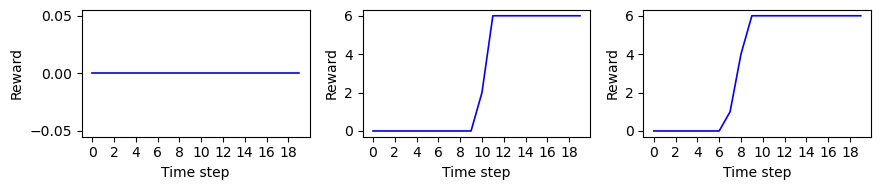

In [61]:
fig, axs = plt.subplots(1, len(num_sample_list), figsize=(3*len(num_sample_list), 2))
for idx, a in enumerate(axs): 
    print(f'num_samples={num_sample_list[idx]}')
    print(f'Training time: {training_time_list[idx]: .4f}s')
    a.plot(reward_list[idx], linewidth=1.2, color='b')
    a.set_xticks(list(range(0, len(reward_list[idx]), 2)))
    a.set_xlabel('Time step', fontsize=10)
    a.set_ylabel('Reward', fontsize=10)
plt.tight_layout()
plt.show()

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> Model-free vs Mode-based RL (20 points)</h3> 

Assume that the dynamics model $s_{t+1} = f(s_t, a_t)$ (when using a probabilistic dynamics model $P(s_{t+1}| s_t, a_t)$) and reward model $R(s_t, a_t)$ are learned from data during training. CEM with learned models can be used to solve similar tasks as model-free reinforcement learning methods such as DDPG.
<br>
In what kind of tasks do you expect CEM with learned models to work better than DDPG? In which kind of tasks do you expect DDPG to work better than CEM with learned models in terms of performance and training time? Why?
<br>
Which parts of CEM with a learned dynamics model need to be taken into account when considering computation time and why?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

1. As we know that ECM improves sampling efficiency by introducing the dynamic model. On relatively simple tasks with low sample efficiency,  ECM can perform better than DDPG by exactly simulating the environment and optimize the policy, insteading of using stochastic update. 
2. When the environment is very complicated, it becomes challenging for the dynamic model to capture. Therefore, DDPG might be more flexible and outperforms ECM when the task environment is very complex. 
3. In terms of training time. When the task is relatively simple and can be learned with limited planning horizons, ECM is likely to take less training time than DDPG.
4. Which part of CEM to take into account: action dimensions and planning horizons, since evaluation on samples will take up most of the computational cost as we have seen in the question 1.1. 

# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex7_MCTS.ipynb```) are answered and the relevant plots are recorded in the relevant places. 

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer to the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)


In [ ]:
hrs = 2.5

2) Difficulty of each task/question from 1-5 (int or float)

In [ ]:
T1 = 3 # Student Task 1. Implementing CEM
Q1 = 2 # Question 1.1: Number of samples
Q2 = 3 # Question 2.1: Model-free vs Model-based

3) How well did you understand the content of the task/question from 1-5? (int or float)


In [ ]:
T1 = 5 # Student Task 1. Implementing CEM
Q1 = 4 # Question 1.1: Number of samples
Q2 = 4 # Question 2.1: Model-free vs Model-based

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
And other feedback you think is worth including. Type in the box below

1. Yes.
2. Quite useful. 

# References <a id='4.'></a>

# Notes for myself

## Crossed Entropy Method
1. Generate random samples (trajectories, vectors, etc) from a certain distribution (policy). 
2. Find out top-$k$ samples with largest regrets produced by the model. 
3. Update the distribution (policy) with good samples, thus that the policy can generate better samples in the next iterate. 

[Crossed Entropy Method](https://zhuanlan.zhihu.com/p/188252023)
## Implementation 
1. ` parallel(delayed(rollout_simulator)(self.model, sample) for sample in action_samples)`: 
    - embarrasingly **parallel for loop**: apply on *each* sample. 
    - arguments and returns type: `NumPy`. 
2. `np.partition` and `np.argpartition`:
    [partition and argpartition](https://www.zhihu.com/question/304282758). 
    
    Perform a partition along given axis by given index. Return a vector of the same shape, where `[0...k-1]` are the smaller elements, `[k...n]` are the larger elements.
    - `np.partition`: return values, `np.argpartition`: return index.
    - Find top k: pass `kth=-topk` to the function; then index by `[-topk:]`

## 3.1 Feedback <a id='3.1'></a>
Good exercise.